In [13]:
# %%writefile boosting_models.py
import numpy as np
import pandas as pd
from pymongo import MongoClient
import pprint
import string
import re
import datetime
import copy

from my_tools import get_bill_data, plot_roc

import statsmodels.api as sm
import scipy.stats as scs
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import normalize
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, mean_squared_error


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB#, ComplementNB unreleased as of 12/14

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
data = get_bill_data()

------------------
------------------
Data is from the 110th Congress (2007) to present
Alter masking in my_tools.get_bill_data to get a different data set.
------------------


In [5]:
# Second iteration removes num_of_cosponsors and bill_char_counts...
# Tried running this using buckets for char_counts. MSE was higher.
data_features = data.loc[:, [
                            'num_of_cosponsors', 
                            'sponsor_party', 
#                             'sponsor_state', 
                            'intro_month', 
                            'session', 
                            'labels', 
                            'bill_char_counts']]

In [6]:
# get dummies for intro_month, sponsor_party, sponsor_state, session
data_dumm = pd.get_dummies(data_features, columns = [
#                                             'intro_month', 
                                            'sponsor_party', 
#                                             'sponsor_state', 
                                            'session'
                                                ], 
                           drop_first=True)

In [7]:
data_dumm.columns

Index(['num_of_cosponsors', 'intro_month', 'labels', 'bill_char_counts',
       'sponsor_party_I', 'sponsor_party_ID', 'sponsor_party_R', 'session_2'],
      dtype='object')

In [8]:
y = data_dumm.pop('labels').values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(data_dumm, y, 
                                                    stratify = y, 
                                                    random_state = 123)

In [ ]:
def stage_score_plot(estimator, X_train, y_train, X_test, y_test):
    '''
        Parameters: estimator: GradientBoostingRegressor or AdaBoostRegressor
                    X_train: 2d numpy array
                    y_train: 1d numpy array
                    X_test: 2d numpy array
                    y_test: 1d numpy array

        Returns: A plot of the number of iterations vs the MSE for the model for
        both the training set and test set.
    '''
    estimator.fit(X_train, y_train)
    name = estimator.__class__.__name__.replace('Regressor', '')
    learn_rate = estimator.learning_rate
    # initialize 
    train_scores = np.zeros((estimator.n_estimators,), dtype=np.float64)
    test_scores = np.zeros((estimator.n_estimators,), dtype=np.float64)
    # Get train score from each boost
    for i, y_train_pred in enumerate(estimator.staged_predict(X_train)):
        train_scores[i] = mean_squared_error(y_train, y_train_pred)
    # Get test score from each boost
    for i, y_test_pred in enumerate(estimator.staged_predict(X_test)):
        test_scores[i] = mean_squared_error(y_test, y_test_pred)
    plt.plot(train_scores, alpha=.5, label="{0} Train - learning rate {1}".format(
                                                                name, learn_rate))
    plt.plot(test_scores, alpha=.5, label="{0} Test  - learning rate {1}".format(
                                                      name, learn_rate), ls='--')
    plt.title(name, fontsize=16, fontweight='bold')
    plt.ylabel('MSE', fontsize=14)
    plt.xlabel('Iterations', fontsize=14)

In [ ]:
gb = GradientBoostingClassifier(learning_rate=.05, n_estimators=100, max_depth=3, random_state=123)
gb_1 = GradientBoostingClassifier(learning_rate=.04, n_estimators=100, max_depth=3, random_state=123)
gb_2 = GradientBoostingClassifier(learning_rate=.02, n_estimators=100, max_depth=3, random_state=123)

In [ ]:
fig = plt.figure(figsize = (16, 8))
stage_score_plot(gb, X_train, y_train, X_test, y_test)
stage_score_plot(gb_1, X_train, y_train, X_test, y_test)
stage_score_plot(gb_2, X_train, y_train, X_test, y_test)
plt.legend()

In [ ]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), 
                         learning_rate=.05, 
                         n_estimators=100, 
                         random_state=123)

ada_2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), 
                         learning_rate=.04, 
                         n_estimators=100, 
                         random_state=123)

ada_3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), 
                         learning_rate=.02, 
                         n_estimators=100, 
                         random_state=123)

In [ ]:
fig = plt.figure(figsize = (16, 8))
stage_score_plot(ada, X_train, y_train, X_test, y_test)
stage_score_plot(ada_2, X_train, y_train, X_test, y_test)
stage_score_plot(ada_3, X_train, y_train, X_test, y_test)
plt.legend()

In [ ]:
# Gradient boosting giving us the lower MSE. At this point, it feels like I'm splitting hairs... 
# the difference in MSE is <.005

In [ ]:
# after examination, going with a learning rate of .05
gb = GradientBoostingClassifier(learning_rate=.05, n_estimators=100, random_state=123)

In [ ]:
gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)

print('----------------------')
print('----------------------')
print('Gradient Boosting Classifier')
print('----------------------')
print('Accuracy score:  {:.2f}'.format(accuracy_score(y_test, gb_y_pred)))
print('Precision score: {:.2f}'.format(precision_score(y_test, gb_y_pred)))
print('Recall score:    {:.2f}'.format(recall_score(y_test, gb_y_pred)))


In [ ]:
gb_y_predict_proba = gb.predict_proba(X_test)

In [ ]:
gb_y_predict_proba[:, 1]

In [9]:
def plot_it(x, y_list, name, labels):
    x = x
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(111)
    ax.set_title(name, fontdict = {'fontsize': 20})
    for y in y_list:
        plt.plot(x, y)
    plt.legend(labels)

    plt.show

In [10]:
# Iterate through several n_estimators to find best 
n_list = range(100, 1600, 100)
r_list = []

print('----------------')
print('Iterating through several n_estimators for Gradient Boost models...')

for n in n_list:
    print('--> n = {}'.format(n))
    gb = GradientBoostingClassifier(learning_rate=.05, n_estimators=n, random_state=123)
    gb.fit(X_train, y_train)
    
    gb_y_pred = gb.predict(X_test)
    r_list.append(recall_score(y_test, gb_y_pred))


----------------
Iterating through several n_estimators for Gradient Boost models...
--> n = 100
--> n = 200
--> n = 300
--> n = 400
--> n = 500
--> n = 600
--> n = 700
--> n = 800
--> n = 900
--> n = 1000
--> n = 1100
--> n = 1200
--> n = 1300
--> n = 1400
--> n = 1500


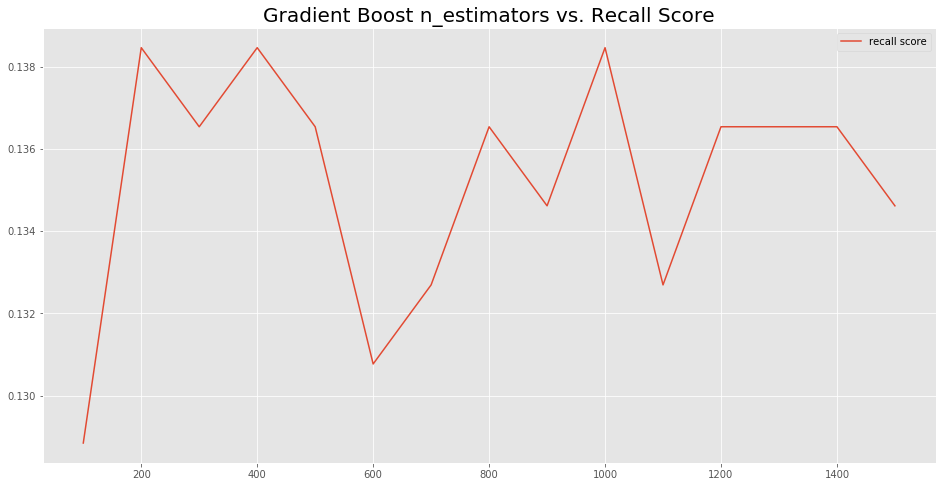

In [11]:
# show graph of scores vs. number of max_features 
x = np.arange(100, 1600, 100)
plot_list = [r_list]
graph_name = 'Gradient Boost n_estimators vs. Recall Score'
labels = ['recall score']

plot_it(x, plot_list, graph_name, labels)

In [15]:
np.argmax(r_list)

1

Text(0.5,0,'Average contribution to information gain')

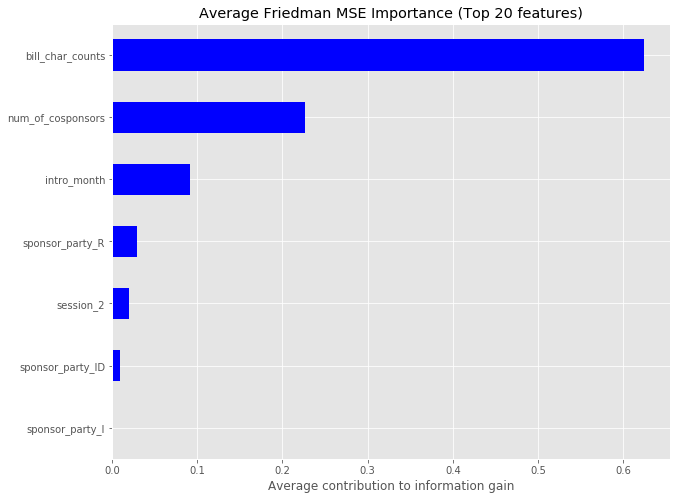

In [12]:
# Plot the feature importance
feat_scores = pd.Series(gb.feature_importances_,
                           index=X_train.columns)
feat_scores = feat_scores.sort_values()[::-1][:20][::-1]
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Friedman MSE Importance (Top 20 features)')
ax.set_xlabel('Average contribution to information gain')

In [18]:
import numpy as np
plot_roc(X_train, y_train, GradientBoostingClassifier, 'Gradient Boost', learning_rate=.05, n_estimators=200)



NameError: name 'np' is not defined